In [1]:
import glob
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

In [2]:
def dico_queue_size(sizes, dic):
    for i in range (len(sizes)):
        if sizes[i] not in dic:
            dic[sizes[i]] = [[], [], []]
    return dic

def compute_means(dico):
    sums = 0
    means = 0
    keys = np.array(list(dico.keys()))
    for i in range (len(keys)):
        means = means+keys[i]*len(dico[keys[i]][0])+keys[i]*len(dico[keys[i]][1])+keys[i]*len(dico[keys[i]][2])
        sums = sums+len(dico[keys[i]][0])+len(dico[keys[i]][1])+len(dico[keys[i]][2])
    return means/sums

def filtrage(dico, nombre_bins, threshold=100):
    dico_p = dict(reversed(list(dico.items())))
    keys = list(dico_p.keys())
    i = 0
    while len(dico_p[keys[i]][0])<threshold:
        i += 1
    values = np.linspace(0, keys[i], nombre_bins, endpoint=True)
    keys = np.array(list(dico.keys()))
    
    real_dic = {}
    for i in range (len(keys)):
        real_k_index = np.argmin(np.abs(values-keys[i]))
        real_k = values[real_k_index]
        
        if real_k not in real_dic:
            real_dic[real_k] = [
                np.array(dico[keys[i]][0]),
                np.array(dico[keys[i]][1]),
                np.array(dico[keys[i]][2])
            ]
        else:
            real_dic[real_k] = [
                np.concatenate([real_dic[real_k][0], dico[keys[i]][0]]),
                np.concatenate([real_dic[real_k][1], dico[keys[i]][1]]),
                np.concatenate([real_dic[real_k][2], dico[keys[i]][2]])
            ]
    return real_dic

def remove_nan_from_dico(dico):
    cleaned_dico = {}
    for key, value_lists in dico.items():
        cleaned_value_lists = []
        for value_list in value_lists:
            value_array = np.array(value_list)
            cleaned_array = value_array[~np.isnan(value_array)]
            cleaned_value_lists.append(cleaned_array.tolist())
        cleaned_dico[key] = cleaned_value_lists
    return cleaned_dico

In [3]:
files_csv = glob.glob(os.path.join("/Volumes/T9/CSV_KHC_NASDAQ_PL", "*.csv"))
dic = {}
means_trades = []
for f in tqdm(files_csv):
    df = pd.read_csv(f)
    df['time_diff'] = df['time_diff']*1.0 # pour le modif en float c'est un timedelta là
    df['imbalance'] = df['imbalance'].round(1)
    df['imbalance'] = np.where(df['side']=='A', df['imbalance'], -df['imbalance'])
    df['imbalance'] = df['imbalance'].shift()
    df = df.dropna()
    df = df[df['action'] == 'T']
    
    sizes = (np.unique(df['imbalance'].to_numpy())).tolist()
    sizes.sort()
    dic = dico_queue_size(sizes, dic)  # Add, Cancel, Trade
    for row in df.itertuples():
        taille = row.imbalance
        dic[taille][2].append(row.time_diff)

dic = dict(sorted(dic.items()))

for i in tqdm(dic):
    means_trades.append(np.mean(dic[i][2]))
print(f"A quel point c'est long: {len(dic)}")


100%|██████████| 21/21 [00:00<00:00, 3656.61it/s]

A quel point c'est long: 21


In [4]:
print(means_trades)

[0.1361126182235477, 0.09465322833342021, 0.19310752632363637, 0.2677909531135687, 0.30659757412867567, 0.3270275638003907, 0.4011967323467219, 0.41548098079542756, 0.4501249668303248, 0.44917482288913, 0.48038486465178953, 0.4515652017820214, 0.46931407870509445, 0.5130352818973277, 0.46543696511916, 0.45545932144357365, 0.35823917688339374, 0.31348290520367345, 0.23606524449049582, 0.12346092907741041, 0.1439848375881281]


In [5]:
file ='/Volumes/T9/CSV_GOOGL_NASDAQ_PL/xnas-itch-20240909.mbp-10.csv'
#file = '/Users/edouard/Desktop/EA p1  HFT/HFT_QR_RL_save/Sans titre/HFT_QR_RL/data/MBO-10 analyse_2/test_csv/xnas-itch-20240726.mbp-10.csv'
df = pd.read_csv(file)
#df = pd.read_csv('/Users/edouard/Desktop/EA p1  HFT/HFT_QR_RL_save/Sans titre/HFT_QR_RL/data/MBO-10 analyse_2/test_csv/xnas-itch-20240726.mbp-10.csv')

dic_bid = {}
dic_ask = {}

df['time_diff'] = df['time_diff']*1.0 # pour le modif en float c'est un timedelta là
df['imbalance'] = df['imbalance'].round(1)
df['imbalance'] = np.where(df['side']=='A', df['imbalance'], -df['imbalance'])
df['imbalance'] = df['imbalance'].shift()
df = df.dropna()
sizes_ask = np.array((np.unique(df['imbalance'].to_numpy())).tolist())
sizes_ask.sort()
sizes_bid = np.array((np.unique(df['imbalance'].to_numpy())).tolist())
sizes_bid.sort()
dic_bid = dico_queue_size(sizes_bid, dic_bid)  # Add, Cancel, Trade
dic_timestamp = dico_queue_size(sizes_bid, dic_bid)
dic_ask = dico_queue_size(sizes_ask, dic_ask)
for row in df.itertuples():
    if row.side == 'A':
        taille = row.imbalance
        if row.action == 'A':
            dic_bid[taille][0].append([row.time_diff,row.ts_event])
        elif row.action == 'C':
            dic_bid[taille][1].append([row.time_diff,row.ts_event])
        elif row.action == 'T':
            dic_bid[taille][2].append([row.time_diff,row.ts_event])
    elif row.side == 'B':
        taille = row.imbalance
        if row.action == 'A':
            dic_bid[taille][0].append([row.time_diff,row.ts_event])
        elif row.action == 'C':
            dic_bid[taille][1].append([row.time_diff,row.ts_event])
        elif row.action == 'T':
            dic_bid[taille][2].append([row.time_diff,row.ts_event])

Add = []
Cancel = []
Trade = []
sizes_add = []
sizes_cancel = []
sizes_trade = []


intensities_bid = dict(sorted(dic_bid.items()))


threshold_trade = 1000
threshold = 100

quarter_add = []
quarter_cancel = []
quarter_trade = []
Add = []
intens = []
print(len(intensities_bid))
l = 0
for i in tqdm(intensities_bid) :
    tab_1 = []
    tab_time = []
    for j in range (len(intensities_bid[i][2])):
        tab_1.append(intensities_bid[i][2][j][0])
        tab_time.append(intensities_bid[i][2][j][1])
    tab_1 = np.array(tab_1)
    tab_1 = tab_1/np.array(means_trades[l])
    l+=1
    intens.append(tab_1)
    Add.append(np.array(pd.to_datetime(tab_time)))

#print(intensities_bid)
intens = np.concatenate(intens)
indices = np.argsort(intens)
intens = intens[indices]
add = np.concatenate(Add)
add = add[indices]
add = add[:int(0.01*len(add))]


prices = df[df['action'] == 'T']['price']
time = pd.to_datetime(df[df['action'] == 'T']['ts_event'])


prices = df[df['action'] == 'T']['price'].reset_index(drop=True)
time = pd.to_datetime(df[df['action'] == 'T']['ts_event']).reset_index(drop=True)

timestamps_numeric = np.array([(ts - add[0]).total_seconds() for ts in add])

# Estimer la densité des points `add`
density_estimator = gaussian_kde(timestamps_numeric)
densities = density_estimator(timestamps_numeric)

densities_normalized = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))

y_min, y_max = np.min(prices) - 0.1, np.max(prices) + 0.1
x_values = np.repeat(add, 50)
y_values = np.random.uniform(y_min, y_max, size=len(x_values))

data = pd.DataFrame({'Timestamp': x_values, 'Price': y_values})


21


100%|██████████| 21/21 [00:00<00:00, 220.99it/s]


/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_79616/865954071.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


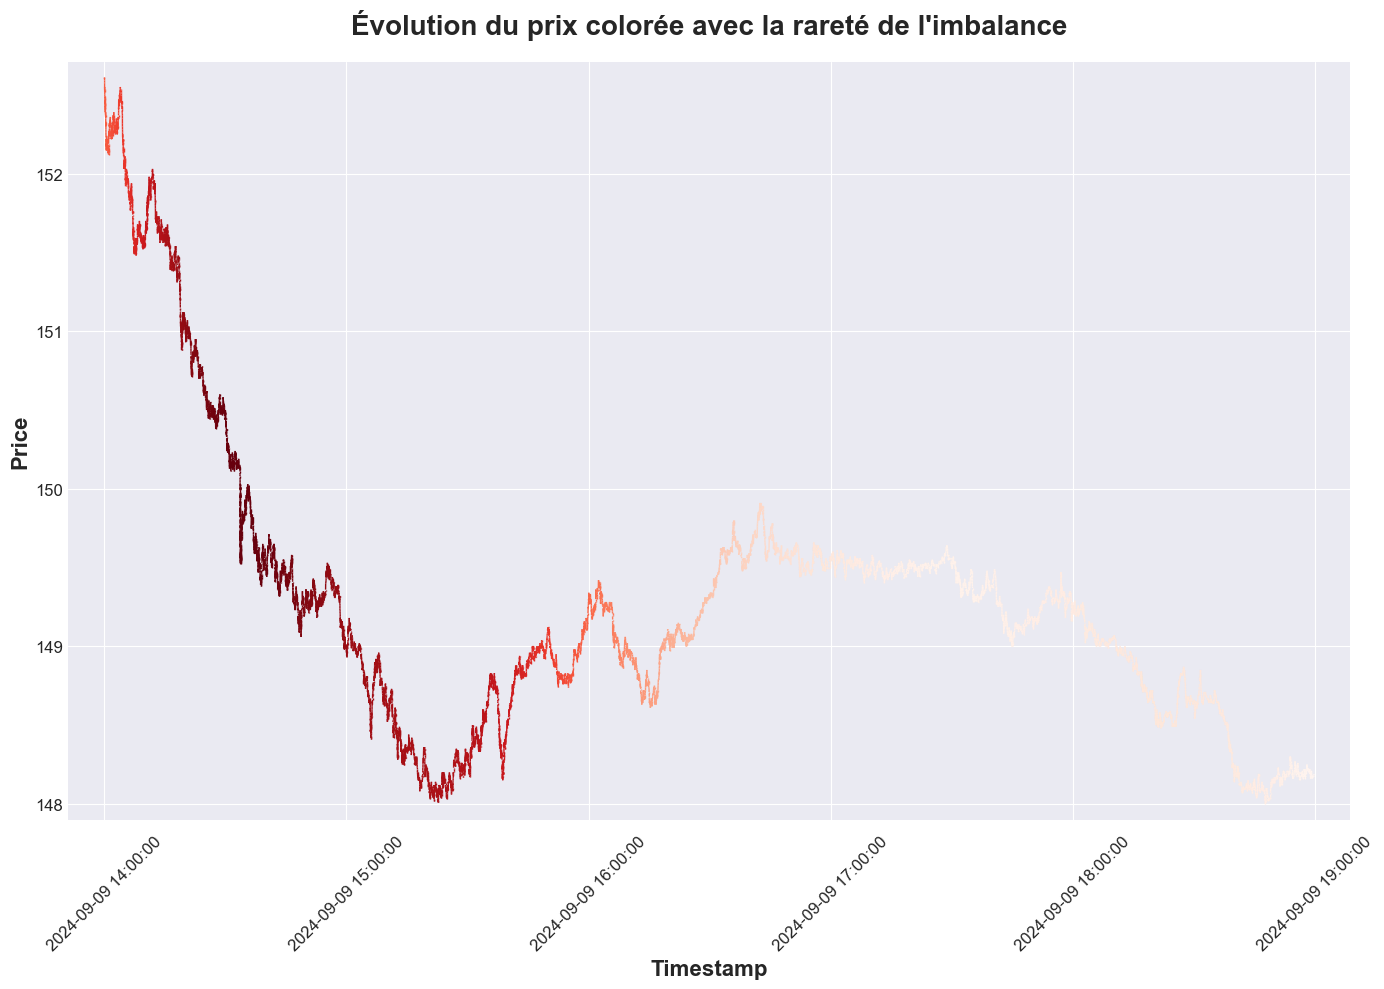

In [6]:
# Données initiales (reprendre votre code donné)
prices = df[df['action'] == 'T']['price'].reset_index(drop=True)
time = pd.to_datetime(df[df['action'] == 'T']['ts_event']).reset_index(drop=True)

timestamps_numeric = np.array([(ts - add[0]).total_seconds() for ts in add])

# Estimer la densité des points `add`
density_estimator = gaussian_kde(timestamps_numeric)

# Calculer la densité pour chaque point de `time` afin de colorer la courbe des prix
timestamps_numeric_prices = np.array([(ts - add[0]).total_seconds() for ts in time])
densities_prices = density_estimator(timestamps_numeric_prices)

# Définition des segments pour la courbe des prix
points = np.array([mdates.date2num(time), prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Création de la colormap et du LineCollection pour la courbe des prix
norm = Normalize(vmin=densities_prices.min(), vmax=densities_prices.max())
cmap = cm.get_cmap("Reds")

# Créer le LineCollection en fonction des densités calculées
lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
lc.set_array(densities_prices)

# Création du graphique
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 10))

# Ajouter la collection au graphique
plt.gca().add_collection(lc)

# Configuration des axes et des étiquettes
plt.title("Évolution du prix colorée avec la rareté de l'imbalance", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=16, fontweight='bold')
plt.ylabel("Price", fontsize=16, fontweight='bold')

# Rotation et formatage des étiquettes de l'axe des x
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.gca().tick_params(axis='x', which='major', pad=10)

# Limites des abscisses
margin = (max(time) - min(time)) * 0.03
plt.xlim(min(time) - margin, max(time) + margin)

# Limites des ordonnées
plt.ylim(prices.min() - 0.1, prices.max() + 0.1)

# Ajustement de la mise en page et affichage
plt.tight_layout()
plt.show()




In [7]:
# Données initiales (reprendre votre code donné)
prices = df[df['action'] == 'T']['price'].reset_index(drop=True)
time = pd.to_datetime(df[df['action'] == 'T']['ts_event']).reset_index(drop=True)

# timestamps_sorted = sorted([ts for sublist in Add for ts in sublist])  # Trier les timestamps
# delta = pd.Timedelta(milliseconds=1000000)  # Critère de proximité temporelle (exemple : 10 ms)

# # Grouper les clusters
# clusters = []
# current_cluster = [timestamps_sorted[0]]

# for i in range(1, len(timestamps_sorted)):
#     if timestamps_sorted[i] - timestamps_sorted[i - 1] <= delta:
#         current_cluster.append(timestamps_sorted[i])
#     else:
#         if len(current_cluster) > 1:  # On garde les clusters d'au moins 2 points
#             clusters.append(current_cluster)
#         current_cluster = [timestamps_sorted[i]]

# if len(current_cluster) > 1:  # Ajouter le dernier cluster s'il est valide
#     clusters.append(current_cluster)

# # Aplatir les clusters pour obtenir tous les points dans les clusters
# timestamps_in_clusters = [ts for cluster in clusters for ts in cluster]

# # Filtrer le DataFrame d'origine avec ces timestamp
# df_filtered = df[df['ts_event'].isin(timestamps_in_clusters)].reset_index(drop=True)
df['ts_event'] = pd.to_datetime(df['ts_event'])
df_filtered = df[df['ts_event'].isin(add)].reset_index(drop=True)


prices_2 = df_filtered['price'].reset_index(drop=True)
time_2 = pd.to_datetime(df_filtered['ts_event'])

fig = go.Figure()
fig.add_trace(go.Scatter(x = time, y = prices, line=dict(color='blue',  width=1)))
fig.add_trace(go.Scatter(x = time_2, y = prices_2, mode = 'markers', marker = dict(color = 'red', size = 4) ))
fig.show()

In [8]:
df = pd.read_csv(file)
df = df[df['action'] == 'T']
timy = np.array(pd.to_datetime(df['ts_event']))

fig = go.Figure()
#fig.add_trace(go.Scatter(x = time, y = prices, line=dict(color='blue',  width=1)))
fig.add_trace(go.Scatter(x = time_2, y = np.arange(len(time_2))/len(time_2), mode = 'markers', marker = dict(color = 'red', size = 4) ))
#fig.add_trace(go.Scatter(x =  [timy[0],timy[len(timy)-1]], y = [0,1], mode = 'lines', line = dict(color = 'blue', width = 2) ))
fig.add_trace(go.Scatter(x = timy, y = (np.arange(len(timy)))/len(timy), mode = 'lines', line = dict(color = 'green', width = 2) ))

fig.show()

In [9]:
counts = []
window_size = 5000
for i in range(len(timy) - window_size):
    start_time = timy[i]
    end_time = timy[i + window_size]
    count = ((add >= start_time) & (add <= end_time)).sum()
    counts.append(count/window_size)
    
fig = go.Figure()
#fig.add_trace(go.Scatter(x = time, y = prices, line=dict(color='blue',  width=1)))
#fig.add_trace(go.Scatter(x = time_2, y = np.arange(len(time_2))/len(time_2), mode = 'markers', marker = dict(color = 'red', size = 4) ))
#fig.add_trace(go.Scatter(x =  [timy[0],timy[len(timy)-1]], y = [0,1], mode = 'lines', line = dict(color = 'blue', width = 2) ))
fig.add_trace(go.Scatter(x = timy, y = counts, mode = 'lines', line = dict(color = 'green', width = 2) ))
print(counts)
fig.show()

[0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.01